## Volatility and Generalized ARCH Processes

In [9]:
# 导入需要的包
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import arch
from statsmodels.stats.diagnostic import acorr_lm
from statsmodels.stats.diagnostic import het_arch
from scipy import stats
import statsmodels.api as sm

### Example 10.1

读入数据

In [10]:
data=pd.read_csv("D:/anaconda3/envs/python36/TimeSeries/dollar.csv")

D:\anaconda3\envs\python36\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


[ 1.00000000e+00  6.02573572e-02 -1.94567570e-02 -1.44126536e-02
  2.25025296e-03  9.72969433e-03  1.09559216e-02  2.65279854e-03
  5.11708126e-03 -4.32802502e-05  2.24241777e-03 -8.50366611e-03
 -1.23082464e-02  1.06197293e-02  1.40446652e-02  2.29685360e-02
  1.31164975e-02  6.61620569e-04 -1.15007250e-02  2.20798591e-02
  2.36861100e-02 -1.51175336e-05 -8.19596884e-03 -2.34188605e-02
 -4.14798029e-03  6.92501847e-03  1.39171467e-03  1.68972941e-02
  2.38366974e-02  1.09748912e-03 -1.79440182e-03 -6.97776062e-03
  1.08800065e-02  1.87311052e-02  1.99114419e-02  1.41053325e-02
 -1.04023132e-02 -1.32680354e-02 -1.50275153e-02  3.61760386e-03
  7.36677938e-03]
[ 1.00000000e+00  6.02629278e-02 -2.31761422e-02 -1.18695299e-02
  3.42933388e-03  8.87002285e-03  9.80791529e-03  1.84878502e-03
  5.53212312e-03 -3.81521414e-04  2.41897199e-03 -8.90458054e-03
 -1.13932510e-02  1.17045254e-02  1.19194982e-02  2.16512108e-02
  1.14391387e-02  7.46751463e-04 -1.05956901e-02  2.34914215e-02
  1.998

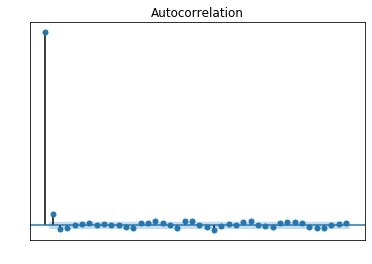

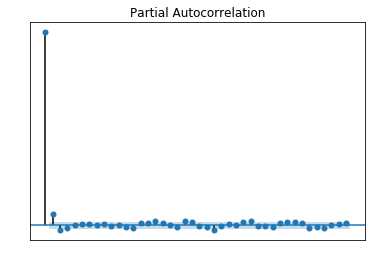

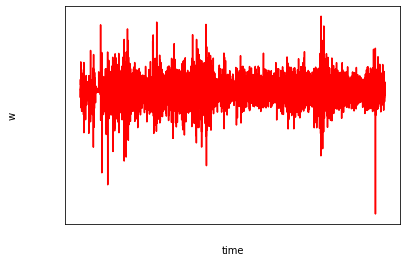

In [3]:
w=data.diff().dropna(axis=0,how='all')
ACF = smt.stattools.acf(w)
PACF=smt.stattools.pacf(w)
print(ACF)
print(PACF)
plot_acf(w)
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plot_pacf(w)
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.show()
plt.plot(w,'r')
plt.ylabel('w')
plt.xlabel('time')
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.show()

可以看出，一阶差分数据类似于白噪声，其ACF和PACF都是只有一阶显著，因此考虑使用AR(1)模型拟合数据。
另一方面，当差分序列用AR(1)过程拟合之后，需要对其残差进行ARCH检验，从而确定其是否符合ARCH模型。

In [4]:
resultAR = AutoReg(w, 1).fit()
resultAR.summary()

D:\anaconda3\envs\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 dollar   No. Observations:                10818
Model:                     AutoReg(1)   Log Likelihood               34237.288
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Tue, 11 Aug 2020   AIC                             -9.168
Time:                        22:24:29   BIC                             -9.166
Sample:                             1   HQIC                            -9.167
                                10818                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -8.603e-05   9.82e-05     -0.876      0.381      -0.000       0.000
dollar.L1      0.0603      0.010      6.279      0.000       0.041       0.079
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           16.5947           +0.0000j           16.5947            0.0000
-----------------------------------------------------------------------------
"""

因此，一阶差分序列符合的模型是w[t]=0.0602*w[t-1]+a[t]

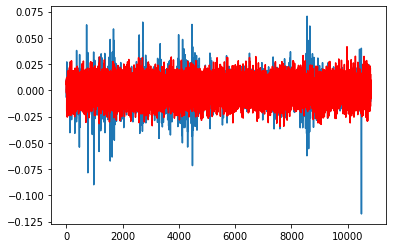

portmanteau统计量结果如下


,lb_stat,lb_pvalue
12,12.270521,0.424206


In [5]:
# 拟合序列：
w_e=[0]*len(w)
w_e[0]=w['dollar'][1]
a=np.random.randn(len(w))*0.01
for t in range(len(w)-1):
    w_e[t+1]=0.0602*w_e[t]+a[t+1]
plt.plot(w)
plt.plot(w_e,'r')
plt.show()
# 计算残差：
m=1 # AR模型的阶数
residual=w['dollar']-w_e
T=len(residual)

at2=residual*residual   # 残差平方和
# 对at2进行白噪声检验
print("portmanteau统计量结果如下")
sm.stats.acorr_ljungbox(resultAR.resid, lags=[12], return_df=True)

白噪声检验的p值0.085>0.05，统计量显著，因此不能拒绝残差具有ARCH效应，因此需要通过GARCH模型对残差进行拟合。

通过计算残差平方和的PACF确定GARCH模型的阶数

[1.         0.08999795 0.0495914  0.07981149 0.05087817 0.0709303
 0.03792827 0.05237231 0.04787955 0.02245064 0.05105667 0.06543127
 0.03821098 0.04390439 0.05174847 0.04800685 0.03755014 0.04146608
 0.03630345 0.0376735  0.03573686 0.03693487 0.01900509 0.05918872
 0.04207293 0.03655705 0.02714436 0.02430941 0.05880183 0.03225358
 0.01469418 0.02707166 0.02554865 0.05439053 0.01969067 0.03042532
 0.0349063  0.04058536 0.05629399 0.03854556 0.02906091]
[ 1.          0.09000627  0.04183838  0.07250358  0.03651266  0.05834806
  0.01900384  0.03773334  0.0287547   0.00484231  0.03529602  0.0476728
  0.01741375  0.02422806  0.03114913  0.02553519  0.01441077  0.02018501
  0.01250926  0.01616817  0.01450272  0.01494402 -0.00418984  0.04152723
  0.01753537  0.01411737  0.00230289  0.00302734  0.03664101  0.00805871
 -0.00811677  0.00451372  0.00609358  0.03522802 -0.0054384   0.01067704
  0.01159811  0.02183668  0.03225319  0.01247496  0.00396745]


D:\anaconda3\envs\python36\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


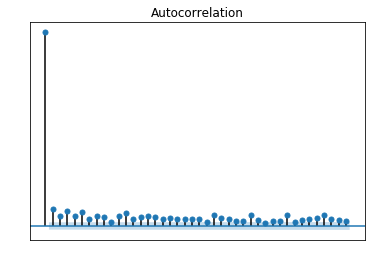

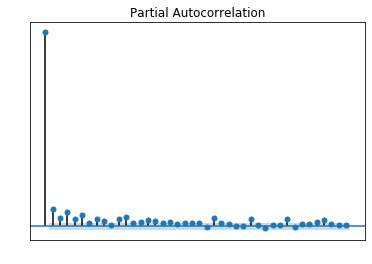

In [6]:
ACF = smt.stattools.acf(at2)
PACF=smt.stattools.pacf(at2)
print(ACF)
print(PACF)
plot_acf(at2)
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plot_pacf(at2)
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.show()

In [7]:
# 最小二乘法拟合残差的平方和
resultAR = AutoReg(at2, 6).fit()
resultAR.summary()


D:\anaconda3\envs\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 dollar   No. Observations:                10818
Model:                     AutoReg(6)   Log Likelihood               69796.109
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Tue, 11 Aug 2020   AIC                            -15.747
Time:                        22:24:29   BIC                            -15.742
Sample:                             6   HQIC                           -15.745
                                10818                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001   5.47e-06     26.686      0.000       0.000       0.000
dollar.L1      0.0773      0.010      8.038      0.000       0.058       0.096
dollar.L2      0.0296      0.010      3.075      0.002       0.011       0.048
dollar.L3      0.0662      0.010      6.872      0.000       0.047       0.085
dollar.L4      0.0312      0.010      3.241      0.001       0.012       0.050
dollar.L5      0.0568      0.010      5.902      0.000       0.038       0.076
dollar.L6      0.0190      0.010      1.977      0.048       0.000       0.038
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4309           -0.0000j            1.4309           -0.0000
AR.2            0.6188           -1.6649j            1.7762           -0.1934
AR.3            0.6188           +1.6649j            1.7762            0.1934
AR.4           -1.3159           -1.4557j            1.9623           -0.3670
AR.5           -1.3159           +1.4557j            1.9623            0.3670
AR.6           -3.0270           -0.0000j            3.0270           -0.5000
-----------------------------------------------------------------------------
"""

In [8]:
am = arch.arch_model(w,mean='AR',lags=1,vol='GARCH') 
res = am.fit()
res.summary()


Iteration:      1,   Func. Count:      7,   Neg. LLF: -35206.35910032051
Iteration:      2,   Func. Count:     23,   Neg. LLF: -35207.293104823606
Iteration:      3,   Func. Count:     40,   Neg. LLF: -32754.931114694136
Iteration:      4,   Func. Count:     57,   Neg. LLF: 77895.301660186
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 77895.30255716067
            Iterations: 4
            Function evaluations: 57
            Gradient evaluations: 4


D:\anaconda3\envs\python36\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001043. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
D:\anaconda3\envs\python36\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 dollar   R-squared:                  -68558.207
Mean Model:                        AR   Adj. R-squared:             -68564.546
Vol Model:                      GARCH   Log-Likelihood:               -77895.3
Distribution:                  Normal   AIC:                           155801.
Method:            Maximum Likelihood   BIC:                           155837.
                                        No. Observations:                10817
Date:                Tue, Aug 11 2020   Df Residuals:                    10812
Time:                        22:24:30   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          2.6790     31.920  8.393e-02      0.933      [-59.884, 65.242]
dollar[1]      0.0433   1080.570  4.006e-05      1.000 [-2.118e+03,2.118e+03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.0862e-06  6.468e-04  3.225e-03      0.997 [-1.266e-03,1.270e-03]
alpha[1]       0.1000      0.681      0.147      0.883      [ -1.235,  1.435]
beta[1]        0.8800      0.869      1.012      0.311      [ -0.824,  2.584]
=============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""

### Example 10.2

通过上例我们可以得知，英镑和美元的汇率时间序列符合如下模型：

x[t]=x[t-1]+e[t]

sigma2[t]=1.36*10e-6+0.068*e[t-1]**2+0.921*sigma2[t-1]

根据第一个式子，可以得知对于任意的h，f_h=1.351。